In [1]:
# import pyvibrate form folder above
import sys, os
sys.path.append(os.path.abspath('..'))
import pyvibrate


In [2]:
from pyvibrate.timedomain import Network, R, C, VSource
import math
# Circuit: Vs -- R -- C -- GND
net = Network()
net, n1 = net.node("n1")  # between Vs and R
net, n2 = net.node("n2")  # between R and C

net, vs = VSource(net, n1, net.gnd, name="vs")
net, r1 = R(net, n1, n2, name="R1")
net, c1 = C(net, n2, net.gnd, name="C1")

# RC = 1ms, so at t=1ms we expect ~63.2% of final value
# at t=5ms we expect ~99.3%
R_val = 1000.0  # 1k ohm
C_val = 1e-6    # 1 µF
tau = R_val * C_val  # 1ms

dt = 1e-6  # 1 µs timestep
sim = net.compile(dt=dt)

params = {"R1": R_val, "C1": C_val, "vs": 0.0}
state = sim.init(params)

# Step voltage to 5V
controls = {"vs": 5.0}

# Simulate for 5 tau
n_steps = int(5 * tau / dt)

v_at_1tau = None
v_at_5tau = None
execution_times = []
import time
execution_times.append(time.perf_counter_ns())
for step in range(n_steps):
    state = sim.step(params, state, controls)
    execution_times.append(time.perf_counter_ns())
    t = float(state.time)
    if abs(t - tau) < dt / 2:
        v_at_1tau = float(sim.v(state, n2))
    if step == n_steps - 1:
        v_at_5tau = float(sim.v(state, n2))

# Expected values
expected_1tau = 5.0 * (1 - math.exp(-1))  # ~3.16V
expected_5tau = 5.0 * (1 - math.exp(-5))  # ~4.97V

# Allow 1% error (numerical integration isn't perfect)
assert v_at_1tau is not None
assert abs(v_at_1tau - expected_1tau) / expected_1tau < 0.01
assert abs(v_at_5tau - expected_5tau) / expected_5tau < 0.01


In [3]:
import numpy

In [13]:

execution_times = numpy.array(execution_times)
execution_times=execution_times[2:-1]  # skip first two steps which include compilation overhead
step_times = numpy.diff(execution_times)  # in nanoseconds
average_step_time_ns = numpy.mean(step_times)
print(f'{average_step_time_ns=:.2f} ns per step, which is {average_step_time_ns/1e6:.6f} ms per step')

average_step_time_ns=167404.56 ns per step, which is 0.167405 ms per step


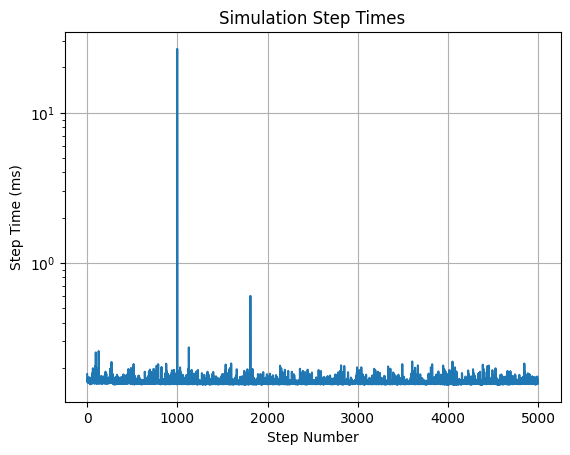

In [14]:
# plot step times vs step number
import matplotlib.pyplot as plt
plt.semilogy(step_times / 1e6)
plt.xlabel('Step Number')
plt.ylabel('Step Time (ms)')
plt.title('Simulation Step Times')
plt.grid()
plt.show()

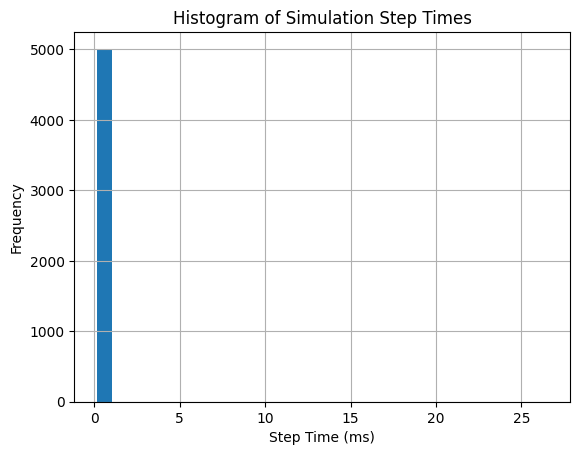

In [15]:
# plot histogram of step times
plt.hist(step_times / 1e6, bins=30)
plt.xlabel('Step Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Simulation Step Times')
plt.grid()
plt.show()

In [7]:
v_at_1tau

3.1598072052001953

In [8]:
v_at_1tau

3.1598072052001953

In [9]:
expected_1tau

3.1606027941427883

In [10]:
state

SimState(time=Array(0.00499978, dtype=float32, weak_type=True), node_voltages=Array([5.      , 4.966646], dtype=float32), cap_voltages=Array([4.966646], dtype=float32), cap_currents=Array([3.354205e-05], dtype=float32), ind_currents=Array([], shape=(0,), dtype=float32), ind_voltages=Array([], shape=(0,), dtype=float32), delay_buffers=Array([0.], dtype=float32), delay_indices=Array([], shape=(0,), dtype=int32))

In [16]:
import time
t_pre = time.perf_counter_ns()
state = sim.step(params, state, controls)
t_post = time.perf_counter_ns()
t_elapsed = t_post - t_pre
t_elapsed

759069